In [1]:
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from time import time
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

# Set plot properties
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({"font.size": 14})

In [2]:
# Paths
main_dir = "../../../data/"
netto_dir = "english_netto_list/"
rand_dir = "english_random_sample/"
comp_dir = "english_complement/"
clip_text = "CLIP_only_images.pkl"
clip_images = "CLIP_without_images.pkl"
clip_text_images = "CLIP_with_images.pkl"

In [3]:
# Load JSON files
def load_json(path):
    f = open(path+"/patent_info.json", 'r')
    data = json.load(f)
    f.close()
    return data

def collect_json(path):
    patent_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return [load_json(path+d) for d in patent_dirs]

def get_text(j):
    return [d["description"]["en"] for d in j]

# Build TF-IDF vectors
def tfidf_data(pos_path, neg_path, min_count=3, max_freq=0.2): 
    # Parse JSON files
    pos_json = collect_json(pos_path)
    neg_json = collect_json(neg_path)
    # Balance data
    set_size = min(len(pos_json), len(neg_json))
    pos_json, neg_json = sample(pos_json, set_size), sample(neg_json, set_size)
    print(set_size, "examples per class")
    # Collect text fields
    documents = get_text(pos_json) + get_text(neg_json)
    # Build TF-IDF vectors using default tokenizer while discarding non-alphabetic tokens
    # Discard words that occur less than min_count times and in more than max_freq of documents
    tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", 
                                       token_pattern=r'(?u)\b[A-Za-z]+\b', min_df=min_count, max_df=max_freq)
    X = tfidf_vectorizer.fit_transform(documents)
    y = np.array([1 for i in range(set_size)]+[0 for i in range(set_size)])
    return X, y

In [4]:
# Load pickled CLIP data
def clip_data(path, pos_label, neg_label):
    with open(path, 'rb') as fp: 
        clip_data = pickle.load(fp)
    X, y = clip_data["X"], clip_data["y"]
    comp_index = (y==pos_label) | (y==neg_label)
    X = X[comp_index]
    y = [1 if i == pos_label else 0 for i in y[comp_index]]
    print(len(y), "examples in total")
    return X, y 

In [8]:
# Cross-validate KNN classifier
def knn_classify(X, y, k_min=1, k_max=49, k_step=2, num_splits=5):
    k_range = range(k_min, k_max+k_step, k_step)
    precision, recall, f1 = [], [], []
    for k in k_range:
        classifier = KNeighborsClassifier(n_neighbors=k)
        # Scores for binary targets where positive examples are assumed to have label 1
        scores = cross_validate(classifier, X, y, cv=num_splits, scoring=["precision", "recall", "f1"])
        precision.append(np.mean(scores["test_precision"]))
        recall.append(np.mean(scores["test_recall"]))
        f1.append(np.mean(scores["test_f1"]))
        print(int(k/k_range[-1]*100)*'|', end='\r')
    return k_range, precision, recall, f1

# Plot validation scores
def plot_scores(k_range, precision, recall, f1, title=None, path=None):
    plt.plot(k_range, precision, label="Precision")
    plt.plot(k_range, recall, label="Recall")
    plt.plot(k_range, f1, label="F-score")
    plt.legend()
    plt.xlabel("k")
    plt.ylabel("Score")
    if title != None: plt.title(title)
    plt.tight_layout()
    if path != None: plt.savefig(path)
    plt.show()

7684 examples per class
6978 examples per class


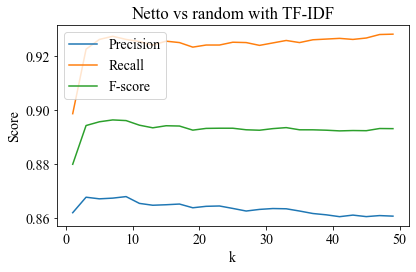

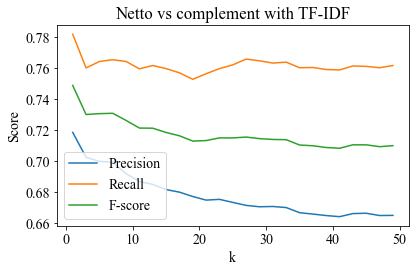

In [9]:
# Evaluate TF-IDF representations and KNN classifier
netto_path = main_dir+netto_dir
X_tfidf_rand, y_tfidf_rand = tfidf_data(netto_path, main_dir+rand_dir)
X_tfidf_comp, y_tfidf_comp = tfidf_data(netto_path, main_dir+comp_dir)
for (X, y, title, file_name) in \
    [(X_tfidf_rand, y_tfidf_rand, "Netto vs random with TF-IDF", "tfidf_random.pdf"),
     (X_tfidf_comp, y_tfidf_comp, "Netto vs complement with TF-IDF", "tfidf_complement.pdf")]:
    k_range, precision, recall, f1 = knn_classify(X, y)
    plot_scores(k_range, precision, recall, f1, title, main_dir+file_name)

13040 examples in total


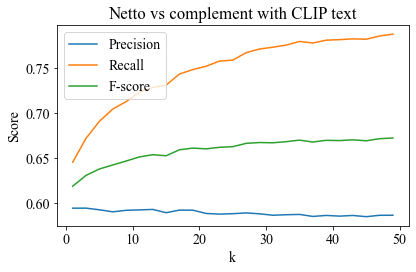

15085 examples in total


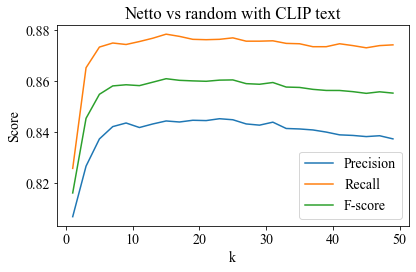

14443 examples in total


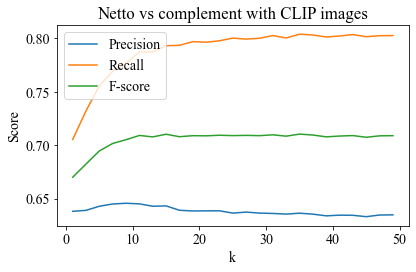

15915 examples in total


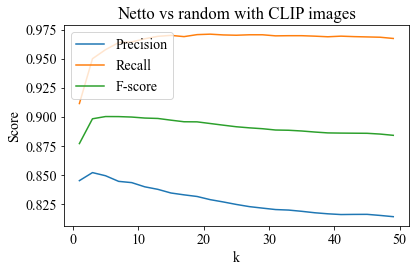

13040 examples in total


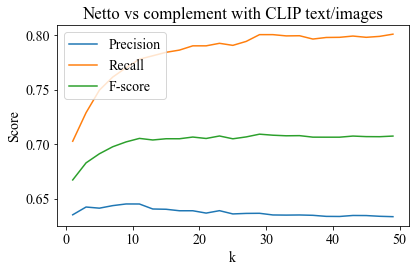

15085 examples in total


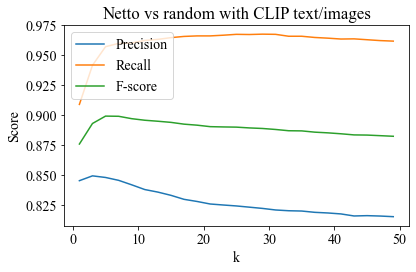

In [10]:
# Evaluate CLIP representations and KNN classifier
for (neg_label, in_file, out_file, title) in \
    [(1, clip_text, "clip_text_complement.pdf", "Netto vs complement with CLIP text"),
     (2, clip_text, "clip_text_random.pdf", "Netto vs random with CLIP text"),
     (1, clip_images, "clip_images_complement.pdf", "Netto vs complement with CLIP images"),
     (2, clip_images, "clip_images_random.pdf", "Netto vs random with CLIP images"),
     (1, clip_text_images, "clip_text_images_complement.pdf", "Netto vs complement with CLIP text/images"),
     (2, clip_text_images, "clip_text_images_random.pdf", "Netto vs random with CLIP text/images")]:
    X, y = clip_data(main_dir+in_file, 0, neg_label)
    k_range, precision, recall, f1 = knn_classify(X, y)
    plot_scores(k_range, precision, recall, f1, title, main_dir+out_file)